In [11]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    TrOCRProcessor, 
    VisionEncoderDecoderModel,
    ViTImageProcessor,
    RobertaTokenizer,
)
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from datasets import (
    load_dataset,
)
from PIL import Image

In [36]:
dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split="train")

def get_training_corpus():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

In [53]:
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
tokenizer.pre_tokenizer.pre_tokenize_str("Partly due to these events")
tokenizer.save("./output/1")

In [54]:
trainer = trainers.BpeTrainer(vocab_size=25000, special_tokens=["<|endoftext|>"])
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

In [55]:
tokenizer.decoder = decoders.ByteLevel()
encoding = tokenizer.encode("Partly due to these events")
print(encoding.ids)
print(tokenizer.decode(encoding.ids))
tokenizer.save("./output/2")

[48, 367, 264, 1309, 227, 1021, 1988]
Partly due to these events


In [32]:
trainer = trainers.BpeTrainer(vocab_size=25000, special_tokens=["<|endoftext|>"])
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

[]


In [26]:
model_name = "./models/trocr-base-printed"
processor = TrOCRProcessor.from_pretrained(model_name, use_fast=False)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.

No chat template is defined for this tokenizer - using a default chat template that implements the ChatML format. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



KeyboardInterrupt: 

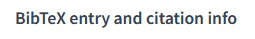

In [8]:
image = Image.open("./data/img/1.jpg").convert("RGB")
image

In [9]:
# training
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
pixel_values = processor(image, return_tensors="pt").pixel_values
text = "BibTeX entry and citation info"
labels = processor.tokenizer(text, return_tensors="pt").input_ids
outputs = model(pixel_values=pixel_values, labels=labels)
loss = outputs.loss
loss

tensor(18.2460, grad_fn=<NllLossBackward0>)

In [12]:
# inference (generation)
pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

'. ENT.'